<a href="https://colab.research.google.com/github/hangjoni/ai-notebooks/blob/main/WWF_Lesson_1_Cat_Dog_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cat & Dog Image Classifier
Classifying 37 breeds of cats and dogs
SOTA benchmark > 90% accuracy

In [1]:
from fastai.vision.all import *

In [7]:
set_seed(42)

In [4]:
path = untar_data(URLs.PETS)

In [8]:
path.ls()[:3]

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/images'),Path('/root/.fastai/data/oxford-iiit-pet/annotations')]

## DataLoader

In [9]:
(path/'images').ls()[:3]

(#3) [Path('/root/.fastai/data/oxford-iiit-pet/images/pomeranian_9.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Maine_Coon_93.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/shiba_inu_187.jpg')]

In [11]:
fnames = get_image_files(path/'images')
pat = r'(.+)_\d+.jpg$'

item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
batch_tfms=[*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
bs = 64

In [16]:
dls = ImageDataLoaders.from_name_re(
    path, # location of data
    fnames, # list of filenames. why do we need fnames when we have path?
    pat, # pattern to extract labels
    item_tfms = item_tfms,
    batch_tfms = batch_tfms,
    bs = bs
)

Zach doesn't like the magics in DataLoaders. Hence we'll try rebuilding the above but using DataBlock API

In [18]:
from torch.cuda.graphs import is_current_stream_capturing
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=RegexLabeller(pat = r'/([^/]+)_\d.*'),
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)

In [19]:
path_im = path/'images'

In [20]:
dls = pets.dataloaders(path_im, bs=bs)

Honestly, except for replacing fnames with get_items=get_image_files, using DataBlock API is as magic as using DataLoader API

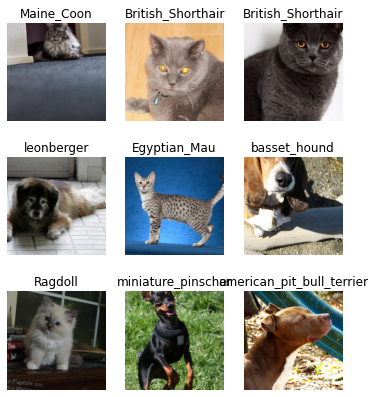

In [21]:
dls.show_batch(max_n=9, figsize=(6,7))

In [22]:
dls.vocab

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']

In [23]:
dls.vocab.o2i

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit_bull_terrier': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker_spaniel': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

## Training the model

Use the pre-trained resnet34 model, and just finetune it

In [24]:
learn = vision_learner(dls, resnet34, metrics=error_rate)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

- Loss function for classification is assumed to be CrossEntropyFlat
- Optimizer defaults to AdamW
- fit_one_cycle (one cycle policy) vs fit_flat_cos (Consine Annealing)

In [25]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.899647,0.379387,0.125169,01:16
1,0.656171,0.287984,0.091340,01:11
2,0.375533,0.251501,0.083897,01:10
3,0.273478,0.249153,0.081191,01:09


In [26]:
learn.save('stage_1')

Path('models/stage_1.pth')

this saves the model to the specified path

## Analyze model performance

In [30]:
interp = ClassificationInterpretation.from_learner(learn)

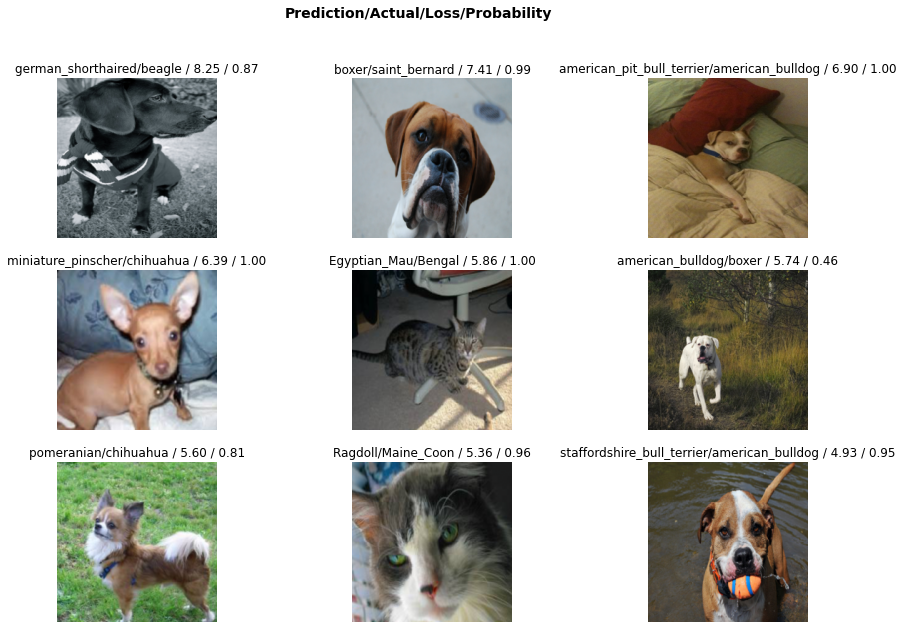

In [31]:
interp.plot_top_losses(9, figsize=(15,10))

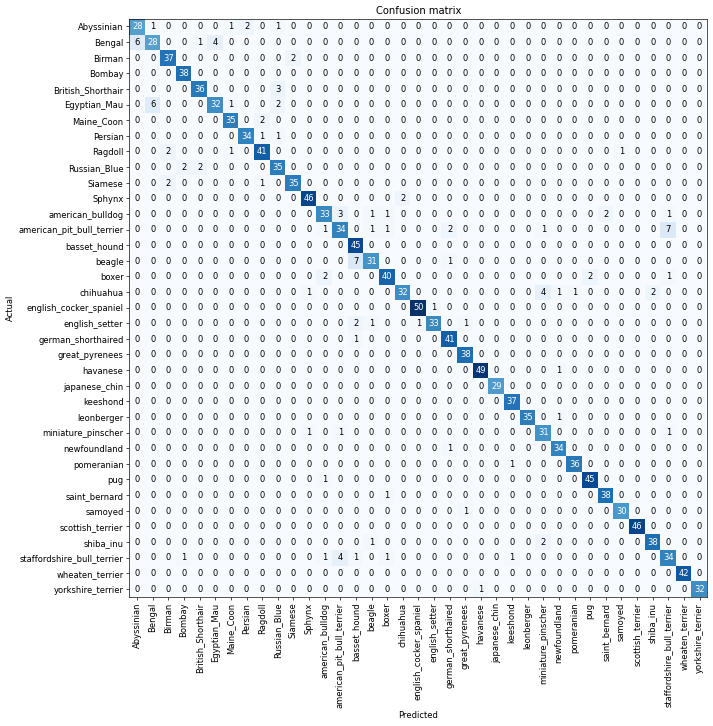

In [32]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [33]:
interp.most_confused(min_val=3)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 7),
 ('beagle', 'basset_hound', 7),
 ('Bengal', 'Abyssinian', 6),
 ('Egyptian_Mau', 'Bengal', 6),
 ('Bengal', 'Egyptian_Mau', 4),
 ('chihuahua', 'miniature_pinscher', 4),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 4),
 ('British_Shorthair', 'Russian_Blue', 3),
 ('american_bulldog', 'american_pit_bull_terrier', 3)]

## Unfreeze and finetune model

In [34]:
learn.load('stage_1');

In [39]:
# unfreeze so we can train the whole model instead of just finetuning the last layer
learn.unfreeze()

SuggestedLRs(valley=6.30957365501672e-05)

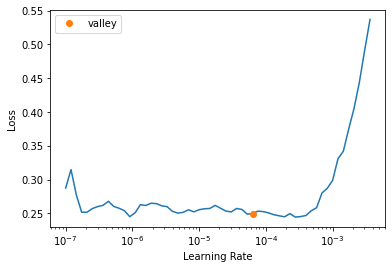

In [40]:
learn.lr_find()

The suggested learning rate is 6e-5

Note how Losses increase where LR near e-2

Hence we choose the slice that contain the suggested learning rate but smaller than the e-2

In [41]:
learn.fit_one_cycle(4, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.251464,0.246763,0.077808,01:26
1,0.215984,0.233359,0.075778,01:13
2,0.200457,0.235351,0.077808,01:11
3,0.182847,0.231661,0.075101,01:12


Some improvement on error rate!

In [ ]:
learn.save('stage_2')